In [2]:
# Code source: Sebastian Curi and Andreas Krause.

# Python Notebook Commands
%matplotlib inline
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

# Numerical Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 5)   # Change this if figures look ugly. 

# IPython Libraries
import IPython
import ipywidgets
from ipywidgets import interact, interactive, interact_manual


# Custom Libraries
from utilities.load_data import polynomial_data
from utilities import plot_helpers
from utilities.regressors import LinearRegressor


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


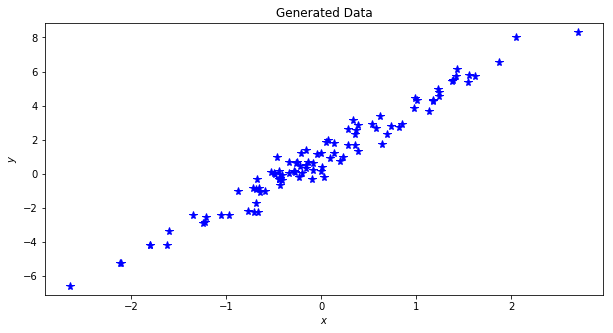

In [3]:
num_points = 100  # Number of training points.
noise = 0.6  # Noise Level (needed for data generation).

a_true = 3  # Slope.
b_true = 1  # Intercept. 
w_true = np.array([a_true, b_true])

X, Y = polynomial_data(num_points, noise, w_true)

# Plot Data
fig = plt.subplot(111);
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Generated Data', 'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5]}
plot_helpers.plot_data(X[:, 0], Y, fig=fig, options=plot_opts)


## Closed Form Solution:

The closed form solution to the regression problem is given by:
$$\hat{w} = (X^\top X)^{-1} X^T y.$$ 

Because there are only 2 parameters, the inverse of $X^\top X$ is fast to do $\approx O(d^3)$. Hence, the closed form can be computed with a total number of operations given by $\approx O(d^3+nd^2)$ .

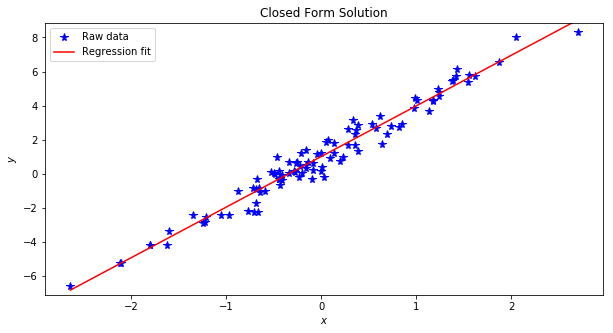

In [4]:
dim = X.shape[1]
reg = 0  # The regularizer is set to zero by now
w_hat_closed_form = np.dot(np.linalg.pinv(np.dot(X.T, X) + reg * np.eye(dim)), np.dot(X.T, Y))
fig = plt.subplot(111)
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Closed Form Solution', 'legend': True,
             'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5]}

plot_helpers.plot_data(X[:, 0], Y, fig=fig, options=plot_opts)
plot_helpers.plot_fit(X, w_hat_closed_form, fig=fig, options=plot_opts)


## Gradient Descent Algorithm:

When the number of dimensions or examples grows, the closed form solution becomes expensive to compute. Hence, the parameters $\hat{w}$ can be updated via a gradient descent rule: 

$$ \hat{w}_{k+1} \gets \hat{w}_k - \eta_k \left.\frac{\partial L}{\partial w} \right|_{w=w_k},$$

where $\eta_k$ is a parameter of the algorithm, $k$ is the iteration index, and $\frac{\partial L}{\partial w}$

The gradients of L with respect to the parameters are:

$$ \frac{\partial L}{\partial \hat{w}} = \frac{1}{N} X^\top(Xw - y) $$ 
In the *vanilla* gradient descent method, $\eta(k)=\eta_0$ is a constant. However other algorithms exists that modify this. We will discuss these later. 

The computational complexity of Gradient descent is $O(n_{\text{iter}} \cdot  n d)$. 

In [ ]:
def gradient_descent(w0, loss_function, opts=dict()):
    """
    Vanilla Gradient descent algorithm. 
    
    w0: is the initial guess
    loss_function: is the loss function you want to optimize. It should have the gradient method. 
    opts: a dictionary with the algorithm parameters 
    """
    w = w0
    dim = w0.size
    
    # Parse the options. 
    eta = opts.get('eta0', 0.01)
    n_iter = opts.get('n_iter', 10)
    
    # Trajectory of iterates w
    trajectory = np.zeros((n_iter + 1, dim))
    trajectory[0, :] = w
    
    for it in range(n_iter):
        # Compute Gradient
        gradient = loss_function.gradient(w)
        
        # Perform gradient step.
        w = w - eta * gradient

        # Save weights.
        trajectory[it + 1, :] = w

    return trajectory



In [ ]:
lr_widget = ipywidgets.FloatSlider(value=1e-1, min=1e-1, max=2, step=1 * 1e-1, readout_format='.1f',
                                   description='Learning rate:', style={'description_width': 'initial'},
                                   continuous_update=False)
n_iter_widget = ipywidgets.IntSlider(value=10, min=5, max=20, step=1, description='Number of iterations:',
                                     style={'description_width': 'initial'}, continuous_update=False)

def change_learning_params_gradient_descent(eta0, n_iter):
    regressor = LinearRegressor(X, Y)
    w0 = np.array([0., 0.])
    opts = {'eta0': eta0, 'n_iter': n_iter}
    trajectory = gradient_descent(w0, regressor, opts)

    contourplot = plt.subplot(121)
    dataplot = plt.subplot(122)
    contour_opts = {'x_label': '$w_0$', 'y_label': '$w_1$', 'title': 'Weight trajectory', 'legend': False,
                   }
    data_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Regression trajectory', 'legend': False, 
                'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5], 'sgd_point': False}
    plot_opts = {'contour_opts': contour_opts, 'data_opts': data_opts}

    plot_helpers.linear_regression_progression(X, Y, trajectory, np.arange(regressor.number_samples), 
                                               regressor.test_loss,
                                               contourplot, dataplot, options=plot_opts)

interact_manual(change_learning_params_gradient_descent, eta0=lr_widget, n_iter=n_iter_widget);


## Stochastic Gradient Descent:

To compute the gradient in stochastic descent, the gradient for each data point must be individually computed and then add them up together. However, each of the data points provides an unbiased estimate (albiet with higher variance) of the expected value of the gradient, i. e.

$$ \mathbb{E}\left[\frac{\partial L(x,y)}{\partial \hat{w}}\right] \approx \frac{\partial L(x_i, y_i)}{\partial \hat{w}} = x_i (x_i^\top \hat{w} - y_i). $$ 

As the gradient depends only on one sample, it is much more noisy and more iterations are needed for convergence. The computational complexity is $O(n_{\text{iter}} \cdot d)$. 

As each gradient step contains significant noise, a desirable property of the algorithm is that the learning rate becomes smaller as it is closer to convergence. If the sequence $eta_k$ satisfy Robbins-Monro condtion,  $\sum_{k=0}^\infty \eta_k = \infty$, $\sum_{k=0}^\infty \eta_k^2 < \infty$ then stochastic gradient descent is guaranteed to converge. For example $\eta_k = \frac{\eta_0}{(k+1)^{0.6}}$ satisfy this requirements. 

In [ ]:
def stochastic_gradient_descent(w0, loss_function, opts=dict()):
    """
    Stochastic Gradient descent algorithm. 
    
    w0: is the initial guess
    loss_function: is the loss function you want to optimize. It should have the gradient method. 
    opts: a dictionary with the algorithm parameters 
    """
    w = w0
    dim = w0.size
    
    # Parse the options. 
    eta = opts.get('eta0', 0.01)
    n_iter = opts.get('n_iter', 10)
    
    # Trajectory of iterates w
    trajectory = np.zeros((n_iter + 1, dim))
    trajectory[0, :] = w
    
    # Trajectory of indexes
    index_traj = np.zeros((n_iter, 1), dtype=np.int)
    
    for it in range(n_iter):
        # Sample index.
        i = np.random.choice(loss_function.number_samples, 1)
        index_traj[it, :] = i

        # Compute Gradient.
        gradient = loss_function.gradient(w, i) # The gradient is only with respect to this point. 

        # Perform gradient step.
        w = w - eta * gradient

        # Save weights.  
        trajectory[it + 1, :] = w

    return trajectory, index_traj


In [ ]:
lr_widget = ipywidgets.FloatSlider(value=1e-1, min=1e-1, max=2, step=1 * 1e-1, readout_format='.1f',
                                   description='Learning rate:', style={'description_width': 'initial'},
                                   continuous_update=False)
n_iter_widget = ipywidgets.IntSlider(value=20, min=5, max=200, step=1, description='Number of iterations:',
                                     style={'description_width': 'initial'}, continuous_update=False)

def change_learning_params_sgd(eta0, n_iter):
    regressor = LinearRegressor(X, Y)
    w0 = np.array([0., 0.])

    opts = {'eta0': eta0,
            'n_iter': n_iter,
            }
    trajectory, indexes = stochastic_gradient_descent(w0, regressor, opts)
        
    contourplot = plt.subplot(121)
    dataplot = plt.subplot(122)
    contour_opts = {'x_label': '$w_0$', 'y_label': '$w_1$', 'title': 'Weight trajectory', 'legend': False}
    data_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Regression trajectory', 'legend': False,
                'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5], 'sgd_point': True}
    plot_opts = {'contour_opts': contour_opts, 'data_opts': data_opts}

    plot_helpers.linear_regression_progression(X, Y, trajectory, indexes, regressor.test_loss,
                                               contourplot, dataplot, options=plot_opts)


interact_manual(change_learning_params_sgd, eta0=lr_widget, n_iter=n_iter_widget);

## Mini-batch Gradient Descent:

A trade-off between full gradient descent (higher cost, lower variance), and stochastic gradient descent (lower cost, higher variance), is done by computing the gradient of a mini-batch of points i.e.
$$ \mathbb{E}\left[\frac{\partial L(x,y)}{\partial \hat{w}}\right] \approx \frac{1}{|B|} \sum_{i\in B} \frac{\partial L(x_i, y_i)}{\partial \hat{w}} = \frac{1}{|B|} \sum_{i\in B} x_i (x_i^\top \hat{w} - y_i). $$ 

The computational complexity is $O(n_{\text{iter}} \cdot |B| d)$. 

In [ ]:
def mini_batch_gradient_descent(w0, loss_function, opts=dict()):
    """
    Mini-Batch Stochastic Gradient descent algorithm. 
    
    w0: is the initial guess
    loss_function: is the loss function you want to optimize. It should have the gradient method. 
    opts: a dictionary with the algorithm parameters 
    """
    w = w0
    dim = w0.size
    
    # Parse the options. 
    eta = opts.get('eta0', 0.01)
    n_iter = opts.get('n_iter', 10)
    batch_size = opts.get('batch_size', 1)
    
    # Trajectory of iterates w
    trajectory = np.zeros((n_iter + 1, dim))
    trajectory[0, :] = w
    
    # Trajectory of indexes
    index_traj = np.zeros((n_iter, batch_size), dtype=np.int)
    
    for it in range(n_iter):
        # Sample index.
        i = np.random.choice(loss_function.number_samples, batch_size, replace=True)
        # If replace=False the estimate becomes BIASED, but its still used in practice when the dataset is large. 
        # Instead of using np.random.choice, the index set is shuffled and then iterate over this shuffled 
        # version sequentially. 
        
        index_traj[it, :] = i

        # Compute Gradient.
        gradient = loss_function.gradient(w, i) # The gradient is only with respect to this point. 

        # Perform gradient step.
        w = w - eta * gradient

        # Save weights.  
        trajectory[it + 1, :] = w

    return trajectory, index_traj


In [ ]:
lr_widget = ipywidgets.FloatSlider(value=1, min=1e-1, max=2, step=1 * 1e-1, readout_format='.1f',
                                   description='Learning rate:', style={'description_width': 'initial'},
                                   continuous_update=False)
n_iter_widget = ipywidgets.IntSlider(value=10, min=5, max=200, step=1, description='Number of iterations:',
                                     style={'description_width': 'initial'}, continuous_update=False)
bs_widget = ipywidgets.IntSlider(value=1, min=1, max=100, step=1, description='Batch Size:',
                                 style={'description_width': 'initial'}, continuous_update=False)
def change_batch_size(eta0, n_iter, batch_size):
    regressor = LinearRegressor(X, Y)
    w0 = np.array([0., 0.])

    opts = {'eta0': eta0,
            'n_iter': n_iter,
            'batch_size': batch_size,
            }
    trajectory, indexes = mini_batch_gradient_descent(w0, regressor, opts)

    contourplot = plt.subplot(121)
    dataplot = plt.subplot(122)
    contour_opts = {'x_label': '$w_0$', 'y_label': '$w_1$', 'title': 'Weight trajectory', 'legend': False}
    data_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Regression trajectory', 'legend': False,
                'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5], 'sgd_point': True}
    plot_opts = {'contour_opts': contour_opts, 'data_opts': data_opts}

    plot_helpers.linear_regression_progression(X, Y, trajectory, indexes, regressor.test_loss,
                                               contourplot, dataplot, options=plot_opts)

interact_manual(change_batch_size, eta0=lr_widget, n_iter=n_iter_widget, batch_size=bs_widget);


## Heuristics to change learning rate

* Bold driver heuristic:

    If $L(x, y, w_k) > L(x, y, w_{k+1})$, 
    
    $\eta_{k+1} = \eta_{k}/5$
    
    else
    
    $\eta_{k+1} \gets \eta_{k}*1.1$

    
* AdaGrad:

    $\eta_k = \frac{\eta_0}{\sqrt{\sum_{j=0}^k g_j^2}}$, where $g_j$ is the 2-norm gradient of $L$ at time $j$. 


* Annealing (From Stochastic Approximation) 

    $\eta_{k} = \frac{\eta_0}{(k+1)^\alpha}$, with $\alpha \in (0.5, 1]$
    
    

In [ ]:
def compute_learning_rate(eta, opts=dict()):
    learning_rate_scheduling = opts.get('learning_rate_scheduling', None)
    eta0 = opts.get('eta0', eta)
    f_increased = opts.get('f_increased', False)
    grad_sum = opts.get('grad_sum', 0)
    it = opts.get('it', 0)
    if learning_rate_scheduling == None:
        eta = eta0  # keep it constant. 
    elif learning_rate_scheduling == 'Annealing':
        eta = eta0 / np.power(it + 1, 0.6)
    elif learning_rate_scheduling == 'Bold driver':
        eta = (eta / 5) if (f_increased) else (eta * 1.1)
    elif learning_rate_scheduling == 'AdaGrad':
        eta = eta0 / np.sqrt(grad_sum)
    elif learning_rate_scheduling == 'Annealing2':
        eta = min([eta0, 100. / (it + 1.)])
    else:
        raise ValueError('Learning rate scheduling {} not understood'.format(method))
    return eta


def gradient_descent(w0, loss_function, opts=dict()):
    """
    Mini-Batch Stochastic Gradient descent algorithm. 
    
    w0: is the initial guess
    loss_function: is the loss function you want to optimize. It should have the gradient and loss method. 
    opts: a dictionary with the algorithm parameters 
    """
    w = w0
    dim = w0.size
    
    # Parse the options. 
    eta = opts.get('eta0', 0.01)
    eta0 = eta
    n_iter = opts.get('n_iter', 10)
    batch_size = opts.get('batch_size', 1)
    learning_rate_scheduling = opts.get('learning_rate_scheduling', None) 
    
    # Trajectory of iterates w
    trajectory = np.zeros((n_iter + 1, dim))
    trajectory[0, :] = w
    
    # Trajectory of indexes
    index_traj = np.zeros((n_iter, batch_size), dtype=np.int)
    
    # Needed for learning rate schedule. 
    f_val = loss_function.loss(w)
    f_old = f_val
    grad_sum = 0
    
    for it in range(n_iter):
        # Sample index.
        i = np.random.choice(loss_function.number_samples, batch_size, replace=True)
        # If replace=False the estimate becomes BIASED, but its still used in practice when the dataset is large. 
        # Instead of using np.random.choice, the index set is shuffled and then iterate over this shuffled 
        # version sequentially. 
        
        index_traj[it, :] = i

        # Compute Gradient.
        gradient = loss_function.gradient(w, i) # The gradient is only with respect to this point. 
        grad_sum += np.sum(np.square(gradient)) # For AdaGrad
        
        # Update learning rate.
        learning_rate_opts = {'learning_rate_scheduling': learning_rate_scheduling,
                              'eta0': eta0,
                              'it': it,
                              'f_increased': (f_val > f_old),
                              'grad_sum': grad_sum}
        # Note it is recursive but eta0 is passed in the options. 
        eta = compute_learning_rate(eta, learning_rate_opts)  
        
        # Perform gradient step.
        w = w - eta * gradient

        # Save weights.  
        trajectory[it + 1, :] = w
        
        # Compute new cost.
        f_old = f_val
        f_val = loss_function.loss(w)

    return trajectory, index_traj

In [ ]:
schedule_widget = ipywidgets.RadioButtons(options=['Bold driver', 'AdaGrad', 'Annealing', 'None'], 
                                          value='Bold driver',  description='Learning rate heuristics:', 
                                          style={'description_width': 'initial'})

def change_heuristics(learning_rate_scheduling=None):
    regressor = LinearRegressor(X, Y)
    w0 = np.array([0., 0.])
    if learning_rate_scheduling == 'None':
        learning_rate_scheduling = None

    opts = {'eta0': 2,
            'n_iter': 10,
            'batch_size': 16,
            'n_samples': X.shape[0],
            'learning_rate_scheduling': learning_rate_scheduling
            }
    trajectory, indexes = gradient_descent(w0, regressor, opts)

    contourplot = plt.subplot(121)
    dataplot = plt.subplot(122)
    contour_opts = {'x_label': '$w_0$', 'y_label': '$w_1$', 'title': 'Weight trajectory', 'legend': False}
    data_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Regression trajectory', 'legend': False,
                'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5]}
    plot_opts = {'contour_opts': contour_opts, 'data_opts': data_opts}

    plot_helpers.linear_regression_progression(X, Y, trajectory, indexes, regressor.test_loss,
                                               contourplot, dataplot, options=plot_opts)

interact_manual(change_heuristics, learning_rate_scheduling=schedule_widget);